In [1]:
!pip install openpyxl textdistance

You should consider upgrading via the '/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import textdistance
from Levenshtein import distance, ratio
from fuzzywuzzy import fuzz

from hc_nlp.constants import ORG_LEGAL_SUFFIXES

# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

pd.options.display.max_rows = None

In [3]:
df = pd.read_excel("../../../GITIGNORE_DATA/NEL/KD copy of review_data.xlsx 240221.xlsx")
df.loc[~df['link_correct'].isnull(), 'link_correct'] = df.loc[~df['link_correct'].isnull(), 'link_correct'].apply(int)
df = df.drop(columns=["item_uri.1", "candidate_uri.1"])
df['ent_label'] = df['ent_label'].map({"PERSON": "PERSON", "OBJECT": "OBJECT", "ORG": "ORGANISATION"})
df['link_correct'] = df['link_correct'].map({0: False, 1: True})
df['_type_match'] = (df['ent_label'] == df['candidate_type'])
df[["ent_text", "candidate_title"]] = df[["ent_text", "candidate_title"]].astype(str)
df['_ent_candidate_distance'] = df.apply(lambda x: distance(x["ent_text"], x["candidate_title"]), axis=1)
df['_ent_candidate_similarity'] = df.apply(lambda x: ratio(x["ent_text"], x["candidate_title"]), axis=1)
df['_ent_candidate_sorted_similarity'] = df.apply(lambda x: fuzz.token_sort_ratio(x["ent_text"], x["candidate_title"])/100, axis=1)

df_annotated = df[~df['link_correct'].isnull()]

len(df), len(df_annotated)

(2852, 567)

In [4]:
df_annotated.head()

,item_uri,candidate_rank,item_description,ent_label,ent_text,candidate_title,candidate_type,candidate_description,link_correct,candidate_uri,candidate_alias,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity
0,https://collection.sciencemuseumgroup.org.uk/o...,0,"Twenty autochromes, mostly of children, by Mrs...",PERSON,E. Janet Laing,Family album of photographs of Janet Marian La...,OBJECT,Family album of photographs of Janet Marian La...,False,https://collection.sciencemuseumgroup.org.uk/o...,NaN,False,48,0.324324,0.33
1,https://collection.sciencemuseumgroup.org.uk/o...,1,"Twenty autochromes, mostly of children, by Mrs...",PERSON,E. Janet Laing,Two hand coloured bromide prints by Janet E,OBJECT,Two hand coloured bromide prints by Janet E. L...,False,https://collection.sciencemuseumgroup.org.uk/o...,NaN,False,36,0.280702,0.36
2,https://collection.sciencemuseumgroup.org.uk/o...,2,"Twenty autochromes, mostly of children, by Mrs...",PERSON,E. Janet Laing,Laing,PERSON,NRM - Pictorial Collection \n \n,False,https://collection.sciencemuseumgroup.org.uk/p...,NaN,True,9,0.526316,0.56
3,https://collection.sciencemuseumgroup.org.uk/o...,3,"Twenty autochromes, mostly of children, by Mrs...",PERSON,E. Janet Laing,"Archer, Janet",PERSON,NRM Pictorial Coll \n \n,False,https://collection.sciencemuseumgroup.org.uk/p...,NaN,True,12,0.444444,0.56
4,https://collection.sciencemuseumgroup.org.uk/o...,4,"Twenty autochromes, mostly of children, by Mrs...",PERSON,E. Janet Laing,"Taylor, Janet",PERSON,"Clifton, G., Directory of British Scientific I...",False,https://collection.sciencemuseumgroup.org.uk/p...,NaN,True,12,0.444444,0.56


## 1. Analysing annotations

In [5]:
print(f"Total number of true annotations: {sum(df_annotated.link_correct)}")
# print(f"Number of entity mentions with at least one true annotation: {(df_annotated.groupby(['item_uri', 'ent_text']).sum() > 0)['link_correct'].sum()}")

Total number of true annotations: 51


#### entity type

is entity type a good predictor of a match? -> **yes**

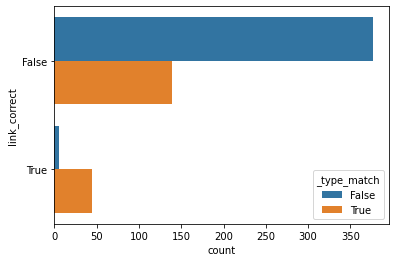

In [6]:
sns.countplot(y="link_correct", hue="_type_match", data=df_annotated);

### 1.1. Planning a Baseline predictor
1. Use **text similarity only** as a predictor of whether an entity mention maps to a SMG record.

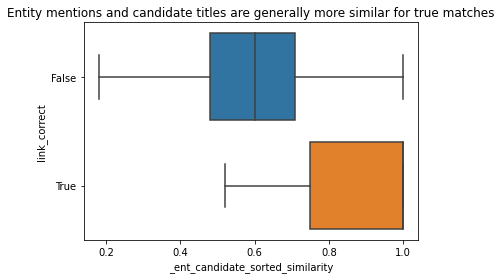

In [7]:
g = sns.boxplot(data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", orient='h', showfliers=False)
g.set_title("Entity mentions and candidate titles are generally more similar for true matches");


2. Use **text similarity and matched type** as a predictor of whether an entity mention maps to an SMG record.

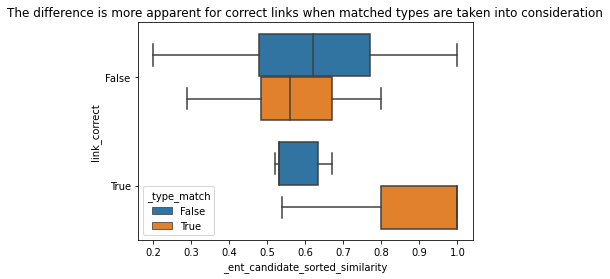

In [8]:
g = sns.boxplot(data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", hue="_type_match", orient='h', showfliers=False)
g.set_title("The difference is more apparent for correct links when matched types are taken into consideration");

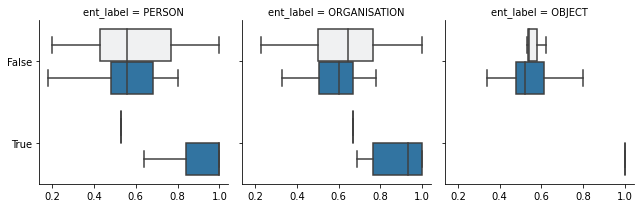

In [9]:
g = sns.FacetGrid(df_annotated, col="ent_label")
g.map_dataframe(sns.boxplot, data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", hue="_type_match", orient='h', showfliers=False)

## 2. Building a Baseline Predictor
- assume an entity mention and record are linked if `fuzz.token_sort_ratio(ent_mention, record_title)` is greater than a threshold, and the predicted entity mention type is the same as the record type
- set this threshold initially to 0.8 based on the above plot and then tune it for accuracy

In [10]:
threshold = 0.8
sim_metric_col = "_ent_candidate_sorted_similarity"

df_annotated['baseline_prediction'] = (df_annotated[sim_metric_col] >= threshold) & (df_annotated["_type_match"])

In [11]:
def calc_metrics(data, gt_col, pred_col):
    tp = len(data[data[gt_col] & data[pred_col]])
    fp = len(data[~data[gt_col] & data[pred_col]])
    tn = len(data[~data[gt_col] & ~data[pred_col]])
    fn = len(data[data[gt_col] & ~data[pred_col]])
    
    acc = (tp + tn) / (tp + fp + tn + fn)
    pr = tp / (tp + fp)
    re = tp / (tp + fn)
    f1 = (2 * pr * re) / (pr + re)
    
    return {"f1": f1, "precision": pr, "recall": re, "accuracy": acc}
    

print("OVERALL")
print(calc_metrics(df_annotated, 'link_correct', 'baseline_prediction'))

for t in ["PERSON", "OBJECT", "ORGANISATION"]:
    print(t)
    print(calc_metrics(df_annotated.loc[df_annotated["ent_label"] == t, :], 'link_correct', 'baseline_prediction'))

OVERALL
{'f1': 0.7640449438202247, 'precision': 0.8947368421052632, 'recall': 0.6666666666666666, 'accuracy': 0.9629629629629629}
PERSON
{'f1': 0.7555555555555555, 'precision': 0.8947368421052632, 'recall': 0.6538461538461539, 'accuracy': 0.945273631840796}
OBJECT
{'f1': 0.8333333333333334, 'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'accuracy': 0.9333333333333333}
ORGANISATION
{'f1': 0.7499999999999999, 'precision': 0.9230769230769231, 'recall': 0.631578947368421, 'accuracy': 0.9761904761904762}


In [12]:
for threshold in (0.6, 0.7, 0.75, 0.8, 0.85):
    df_annotated['baseline_prediction'] = (df_annotated[sim_metric_col] >= threshold) & (df_annotated["_type_match"])
    
    print(f"--- {threshold} ---")
    print(calc_metrics(df_annotated, 'link_correct', 'baseline_prediction'))

    for t in ["PERSON", "OBJECT", "ORGANISATION"]:
        print(t)
        print(calc_metrics(df_annotated.loc[df_annotated["ent_label"] == t, :], 'link_correct', 'baseline_prediction'))

--- 0.6 ---
{'f1': 0.5584415584415585, 'precision': 0.4174757281553398, 'recall': 0.8431372549019608, 'accuracy': 0.8800705467372134}
PERSON
{'f1': 0.5714285714285714, 'precision': 0.45454545454545453, 'recall': 0.7692307692307693, 'accuracy': 0.8507462686567164}
OBJECT
{'f1': 0.5882352941176471, 'precision': 0.45454545454545453, 'recall': 0.8333333333333334, 'accuracy': 0.7666666666666667}
ORGANISATION
{'f1': 0.537313432835821, 'precision': 0.375, 'recall': 0.9473684210526315, 'accuracy': 0.9077380952380952}
--- 0.7 ---
{'f1': 0.7207207207207207, 'precision': 0.6666666666666666, 'recall': 0.7843137254901961, 'accuracy': 0.9453262786596119}
PERSON
{'f1': 0.6545454545454545, 'precision': 0.6206896551724138, 'recall': 0.6923076923076923, 'accuracy': 0.9054726368159204}
OBJECT
{'f1': 0.8333333333333334, 'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'accuracy': 0.9333333333333333}
ORGANISATION
{'f1': 0.7727272727272727, 'precision': 0.68, 'recall': 0.8947368421052632, 'acc

## 3. Building a machine learning predictor
Using only the mention, title, and types of each.

In [13]:
from sklearn.preprocessing import OneHotEncoder
from typing import List


class FeatureGenerator:
    def __init__(self, data: pd.DataFrame, ent_mention_col: str, ent_type_col: str, ent_context_col: str, candidate_title_col: str, candidate_type_col: str, candidate_context_col: str):
        self.data = data
        
        # TODO: do lowercase transformation here to make all methods case-insensitive
        
        self.ent_mention_col = self.data[ent_mention_col]
        self.ent_type_col = self.data[ent_type_col]
        self.ent_context_col = self.data[ent_context_col]
        self.candidate_title_col = self.data[candidate_title_col]
        self.candidate_type_col = self.data[candidate_type_col]
        self.candidate_context_col = self.data[candidate_context_col]
        
        self.n_records = self.data.shape[0]
        
        self.suffix_list = ORG_LEGAL_SUFFIXES
        
        self.ent_type_encoder = OneHotEncoder().fit(self.ent_type_col.unique().reshape(-1, 1))
        self.candidate_type_encoder = OneHotEncoder().fit(self.candidate_type_col.unique().reshape(-1, 1))
    
    @staticmethod
    def _remove_suffixes(text: str, suffix_list: List[str]) -> str:
        """
        Returns lowercased version of text with any of the suffixes in suffix_list removed. Case-insensitive.
        """
        mod_text = text[:-1].lower() if text[-1] == "." else text.lower()

        for suffix in suffix_list:
            if mod_text.endswith(suffix.lower()):
                mod_text = mod_text.rstrip(suffix.lower()).strip()

                break

        return mod_text
    
    def _apply_string_sim_method(self, method, col_a: pd.Series, col_b: pd.Series, token_wise: bool, denominator: int = 1) -> np.ndarray:
        """
        Params:
        - token_wise (bool): if True, split each string by spaces (`method` is passed two sequences rather than two strings)
        """
        if token_wise:
            return np.array([[method(col_a.iloc[idx].split(), col_b.iloc[idx].split()) / denominator] if all([pd.notnull(col_a.iloc[idx]), pd.notnull(col_b.iloc[idx])]) else [0] for idx in range(self.n_records)])
        else:
            return np.array([[method(col_a.iloc[idx], col_b.iloc[idx]) / denominator] if all([pd.notnull(col_a.iloc[idx]), pd.notnull(col_b.iloc[idx])]) else [0] for idx in range(self.n_records)])
        
    def _generate_similarity_fuzz_sort(self, col_a: pd.Series, col_b: pd.Series, **kwargs) -> np.ndarray:
        return self._apply_string_sim_method(fuzz.token_sort_ratio, col_a, col_b, denominator=100, token_wise=False)
    
    def _generate_similarity_levenshtein(self, col_a: pd.Series, col_b: pd.Series, **kwargs) -> np.ndarray:
        return self._apply_string_sim_method(textdistance.levenshtein.normalized_similarity, col_a, col_b, token_wise=False)
    
    def _generate_similarity_jarowinkler(self, col_a: pd.Series, col_b: pd.Series, **kwargs) -> np.ndarray:
        return self._apply_string_sim_method(textdistance.jaro_winkler.normalized_similarity, col_a, col_b, token_wise=False)
    
    def _generate_similarity_jaccard(self, col_a: pd.Series, col_b: pd.Series, **kwargs) -> np.ndarray:
        return self._apply_string_sim_method(textdistance.jaccard.normalized_similarity, col_a, col_b, token_wise=True)
    
    def _generate_similarity_sorensen_dice(self, col_a: pd.Series, col_b: pd.Series, **kwargs) -> np.ndarray:
        return self._apply_string_sim_method(textdistance.sorensen_dice.normalized_similarity, col_a, col_b, token_wise=True)
    
    def _generate_ml_similarity_fuzz_sort_ignore_suffixes(self, **kwargs) -> np.ndarray:
        
        if "string_sim_metric" in kwargs:
            return np.array([[kwargs["string_sim_metric"](self.ent_mention_col.iloc[idx], self.candidate_title_col.iloc[idx]) / 100] for idx in range(self.n_records) ])
        
        else:
            return np.array([[fuzz.token_sort_ratio(
                self._remove_suffixes(self.ent_mention_col.iloc[idx], self.suffix_list), 
                self._remove_suffixes(self.candidate_title_col.iloc[idx], self.suffix_list)
            ) / 100] for idx in range(self.n_records) ])
    
    def _generate_label_in_mention(self, **kwargs) -> np.ndarray:
        return np.array(
            [[float(self.candidate_title_col.iloc[idx].lower() in self.ent_mention_col.iloc[idx].lower())] for idx in range(self.n_records)]
        )
    
    def _generate_mention_in_label(self, **kwargs) -> np.ndarray:
        return np.array(
            [[float(self.ent_mention_col.iloc[idx].lower() in self.candidate_title_col.iloc[idx].lower())] for idx in range(self.n_records)]
        )

    
    def _generate_type_features(self, **kwargs) -> np.ndarray:
        return np.concatenate(
            (
                self.ent_type_encoder.transform(self.ent_type_col.values.reshape(-1,1)).toarray(), 
                self.candidate_type_encoder.transform(self.candidate_type_col.values.reshape(-1,1)).toarray()
            ), 
            axis=1)
    
    def get_feature_matrix(self) -> np.ndarray:
        
        feature_rows = np.concatenate(
            (
                self._generate_similarity_fuzz_sort(self.ent_mention_col, self.candidate_title_col),
                self._generate_similarity_levenshtein(self.ent_mention_col, self.candidate_title_col),
                self._generate_similarity_jarowinkler(self.ent_mention_col, self.candidate_title_col),
                self._generate_ml_similarity_fuzz_sort_ignore_suffixes(),
                self._generate_similarity_jarowinkler(self.ent_context_col, self.candidate_context_col),
                self._generate_similarity_jaccard(self.ent_context_col, self.candidate_context_col),
                self._generate_similarity_sorensen_dice(self.ent_context_col, self.candidate_context_col),
                self._generate_label_in_mention(),
                self._generate_mention_in_label(),
                self._generate_type_features(),
            ), 
            axis=1
        )
        
        return feature_rows
        

In [14]:
f = FeatureGenerator(df_annotated, 
                     ent_mention_col='ent_text', ent_type_col='ent_label', ent_context_col='item_description', 
                     candidate_title_col='candidate_title', candidate_type_col='candidate_type', candidate_context_col='candidate_description')

X = f.get_feature_matrix()
y = 1*(df_annotated['link_correct'].values)

In [15]:
i = 0
n = 10

for idx, row in df_annotated.head(n).iterrows():
    print(row['ent_text'], "---" ,row['candidate_title'], X[i, [5]])
    i += 1

E. Janet Laing --- Family album of photographs of Janet Marian Laing (later Mrs [0.10344828]
E. Janet Laing --- Two hand coloured bromide prints by Janet E [0.25]
E. Janet Laing --- Laing [0.]
E. Janet Laing --- Archer, Janet [0.]
E. Janet Laing --- Taylor, Janet [0.02247191]
Unknown maker --- Unknown maker [0.]
Unknown maker --- Wellplate, unknown maker [0.]
Unknown maker --- Haemagglutination plate, unknown maker [0.]
Unknown maker --- Test tube, unknown maker [0.]
Unknown maker --- Test tube, unknown maker [0.]


In [16]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=1, random_state=42)
scores = cross_validate(clf, X, list(y), cv=10, scoring=['precision_macro', 'recall_macro'])

(scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())

((0.9440087375936432, 0.06721181749897512),
 (0.8294683257918551, 0.07772323471888948))

In [17]:
from sklearn.linear_model import LogisticRegressionCV

log_r = LogisticRegressionCV(cv=5, random_state=0, max_iter=500).fit(X, list(y))

scores = cross_validate(log_r, X, list(y), cv=10, scoring=['precision_macro', 'recall_macro'])

(scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())

((0.9319351319539999, 0.09079945588001051),
 (0.8192119155354449, 0.06968056295106001))

In [18]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0, max_iter=1000)

scores = cross_validate(mlp, X, list(y), cv=10, scoring=['precision_macro', 'recall_macro'])

(scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())

((0.9525607737927382, 0.0771046996206504),
 (0.8478205128205127, 0.09371312555549878))

### 3.1 Test on unannotated data

In [19]:
df_unannotated = df[df['link_correct'].isnull()]
len(df_unannotated)

2285

In [20]:
f_un = FeatureGenerator(df_unannotated, 
                     ent_mention_col='ent_text', ent_type_col='ent_label', ent_context_col='item_description', 
                     candidate_title_col='candidate_title', candidate_type_col='candidate_type', candidate_context_col='candidate_description')

X_un = f_un.get_feature_matrix()

X_un.shape

(2285, 15)

In [21]:
classifier = mlp.fit(X, list(y))

df_unannotated['log_r_prediction'] = classifier.predict(X_un)
df_unannotated['log_r_prediction_proba'] = classifier.predict_proba(X_un)[:,1]

In [22]:
df_unannotated[df_unannotated['log_r_prediction'] == 1].head(50)
# df_unannotated.head(20)

df_unannotated[df_unannotated['log_r_prediction'] == 1].to_csv("pos_preds.csv")

## 4. Building a pairwise ranking classifier

### 4.1 RankSVM

In [157]:
from sklearn.preprocessing import OneHotEncoder
from typing import List


class FeatureGenerator:
    def __init__(self, data: pd.DataFrame, source_uri_col: str, ent_mention_col: str, ent_type_col: str, ent_context_col: str, candidate_title_col: str, candidate_type_col: str, candidate_context_col: str):
        self.data = data
        
        # TODO: do lowercase transformation here to make all methods case-insensitive
        self.data = data
        self.source_uri_col = self.data[source_uri_col]
        self.ent_mention_col = self.data[ent_mention_col]
        self.ent_type_col = self.data[ent_type_col]
        self.ent_context_col = self.data[ent_context_col]
        self.candidate_title_col = self.data[candidate_title_col]
        self.candidate_type_col = self.data[candidate_type_col]
        self.candidate_context_col = self.data[candidate_context_col]
        
        self.n_records = self.data.shape[0]
        
        self.suffix_list = ORG_LEGAL_SUFFIXES
        
        self.ent_type_encoder = OneHotEncoder().fit(self.ent_type_col.unique().reshape(-1, 1))
        self.candidate_type_encoder = OneHotEncoder().fit(self.candidate_type_col.unique().reshape(-1, 1))
    
    @staticmethod
    def _remove_suffixes(text: str, suffix_list: List[str]) -> str:
        """
        Returns lowercased version of text with any of the suffixes in suffix_list removed. Case-insensitive.
        """
        mod_text = text[:-1].lower() if text[-1] == "." else text.lower()

        for suffix in suffix_list:
            if mod_text.endswith(suffix.lower()):
                mod_text = mod_text.rstrip(suffix.lower()).strip()

                break

        return mod_text
    
    def _apply_string_sim_method(self, method, col_a: pd.Series, col_b: pd.Series, token_wise: bool, denominator: int = 1) -> np.ndarray:
        """
        Params:
        - token_wise (bool): if True, split each string by spaces (`method` is passed two sequences rather than two strings)
        """
        if token_wise:
            return np.array([[method(col_a.iloc[idx].split(), col_b.iloc[idx].split()) / denominator] if all([pd.notnull(col_a.iloc[idx]), pd.notnull(col_b.iloc[idx])]) else [0] for idx in range(self.n_records)])
        else:
            return np.array([[method(col_a.iloc[idx], col_b.iloc[idx]) / denominator] if all([pd.notnull(col_a.iloc[idx]), pd.notnull(col_b.iloc[idx])]) else [0] for idx in range(self.n_records)])
        
    def _generate_similarity_fuzz_sort(self, col_a: pd.Series, col_b: pd.Series, **kwargs) -> np.ndarray:
        return self._apply_string_sim_method(fuzz.token_sort_ratio, col_a, col_b, denominator=100, token_wise=False)
    
    def _generate_similarity_levenshtein(self, col_a: pd.Series, col_b: pd.Series, **kwargs) -> np.ndarray:
        return self._apply_string_sim_method(textdistance.levenshtein.normalized_similarity, col_a, col_b, token_wise=False)
    
    def _generate_similarity_jarowinkler(self, col_a: pd.Series, col_b: pd.Series, **kwargs) -> np.ndarray:
        return self._apply_string_sim_method(textdistance.jaro_winkler.normalized_similarity, col_a, col_b, token_wise=False)
    
    def _generate_similarity_jaccard(self, col_a: pd.Series, col_b: pd.Series, **kwargs) -> np.ndarray:
        return self._apply_string_sim_method(textdistance.jaccard.normalized_similarity, col_a, col_b, token_wise=True)
    
    def _generate_similarity_sorensen_dice(self, col_a: pd.Series, col_b: pd.Series, **kwargs) -> np.ndarray:
        return self._apply_string_sim_method(textdistance.sorensen_dice.normalized_similarity, col_a, col_b, token_wise=True)
    
    def _generate_ml_similarity_fuzz_sort_ignore_suffixes(self, **kwargs) -> np.ndarray:
        
        if "string_sim_metric" in kwargs:
            return np.array([[kwargs["string_sim_metric"](self.ent_mention_col.iloc[idx], self.candidate_title_col.iloc[idx]) / 100] for idx in range(self.n_records) ])
        
        else:
            return np.array([[fuzz.token_sort_ratio(
                self._remove_suffixes(self.ent_mention_col.iloc[idx], self.suffix_list), 
                self._remove_suffixes(self.candidate_title_col.iloc[idx], self.suffix_list)
            ) / 100] for idx in range(self.n_records) ])
    
    def _generate_label_in_mention(self, **kwargs) -> np.ndarray:
        return np.array(
            [[float(self.candidate_title_col.iloc[idx].lower() in self.ent_mention_col.iloc[idx].lower())] for idx in range(self.n_records)]
        )
    
    def _generate_mention_in_label(self, **kwargs) -> np.ndarray:
        return np.array(
            [[float(self.ent_mention_col.iloc[idx].lower() in self.candidate_title_col.iloc[idx].lower())] for idx in range(self.n_records)]
        )

    
    def _generate_type_features(self, **kwargs) -> np.ndarray:
        return np.concatenate(
            (
                self.ent_type_encoder.transform(self.ent_type_col.values.reshape(-1,1)).toarray(), 
                self.candidate_type_encoder.transform(self.candidate_type_col.values.reshape(-1,1)).toarray()
            ), 
            axis=1)
    
    def get_feature_matrix(self) -> np.ndarray:
        
        feature_rows = np.concatenate(
            (
                self._generate_similarity_fuzz_sort(self.ent_mention_col, self.candidate_title_col),
                self._generate_similarity_levenshtein(self.ent_mention_col, self.candidate_title_col),
                self._generate_similarity_jarowinkler(self.ent_mention_col, self.candidate_title_col),
                self._generate_ml_similarity_fuzz_sort_ignore_suffixes(),
                self._generate_similarity_jarowinkler(self.ent_context_col, self.candidate_context_col),
                self._generate_similarity_jaccard(self.ent_context_col, self.candidate_context_col),
                self._generate_similarity_sorensen_dice(self.ent_context_col, self.candidate_context_col),
                self._generate_label_in_mention(),
                self._generate_mention_in_label(),
                self._generate_type_features(),
            ), 
            axis=1
        )
        
        return feature_rows
    
    @staticmethod
    def group_data_by_source(data: pd.DataFrame) -> List[pd.DataFrame]:
        # TODO: make column names in __init__ strings rather than series and pass them to groupby here
        return [_slice for (_, _slice) in data.groupby(["item_uri", "ent_text", "ent_label"])]
    
    def get_data_with_features(self) -> pd.DataFrame:
        """Adds X to the end of the dataframe in columns with names 'feat_i' and returns it"""
        
        X = self.get_feature_matrix()
        feat_cols = [f"feat{i}" for i in range(X.shape[1])]
        
        return pd.concat([self.data.reset_index(drop=True), pd.DataFrame(X, columns=feat_cols)], axis=1)
    
    def get_pairwise_features_and_targets(self) -> np.ndarray:
        # TODO: put this in __init__
        target_col = 'link_correct'
        ##
        
        X_pairwise = []
        y_pairwise = []
        
        X = self.get_feature_matrix()
        feat_cols = [f"feat{i}" for i in range(X.shape[1])]
#         data_with_X = pd.concat([self.data.reset_index(), pd.DataFrame(X, columns=feat_cols)], axis=1)
        data_with_X = self.get_data_with_features()
        
        for group_data in self.group_data_by_source(data_with_X):
            pos_idxs = group_data[group_data[target_col] == True].index
            neg_idxs = group_data[group_data[target_col] == False].index
                            
            X_g = []
            y_g = []

            for pos_idx in pos_idxs:
                for neg_idx in neg_idxs:
                    X_g.append(group_data.loc[pos_idx, feat_cols].values - group_data.loc[neg_idx, feat_cols].values)
                    y_g.append(1)

                    X_g.append(group_data.loc[neg_idx, feat_cols].values - group_data.loc[pos_idx, feat_cols].values)
                    y_g.append(-1)
                    
            X_pairwise += X_g
            y_pairwise += y_g
            
        return np.array(X_pairwise), np.array(y_pairwise)

In [158]:
f = FeatureGenerator(df_annotated, 
                         source_uri_col = 'item_uri', 
                         ent_mention_col='ent_text', ent_type_col='ent_label', ent_context_col='item_description', 
                         candidate_title_col='candidate_title', candidate_type_col='candidate_type', candidate_context_col='candidate_description')

X_p, y_p = f.get_pairwise_features_and_targets()

X_p.shape, y_p.shape

((434, 15), (434,))

In [167]:
from sklearn import svm
from scipy import linalg

class RankSVM():
    def fit(self, X_train: np.ndarray, y_train: np.ndarray, verbose=False):
        clf = svm.LinearSVC(dual=False, verbose=verbose)
        clf.fit(X_train, y_train)

        self.model = clf
        self._weights = self.model.coef_.ravel() / linalg.norm(self.model.coef_)
        
        return self

    def rank(self, group: pd.DataFrame) -> List[int]:
        feat_cols = [col for col in group.columns if col.startswith('feat')]
        X = group[feat_cols].values
        
        scores = X.dot(self._weights)

        scored_group = group.assign(rerank_scores=scores)
        scored_group.sort_values("rerank_scores", inplace=True, ascending=False)
        
        return scored_group
#         result = scored_group["candidate_id"].astype(np.int).values

#         return list(result)

    def explain(self, features: List[str]) -> List:
        # Gene Selection for Cancer Classification using Support Vector Machines

        results = []
        scores = self._weights * self._weights
        scores = normalize(scores.reshape(1, -1), norm="l1").squeeze()

        for w, l in zip(scores, features):
            results.append({"feature": l, "weight": w})



In [168]:
pair_clf = RankSVM().fit(X_p, y_p)

In [169]:
f_un = FeatureGenerator(df_unannotated, 
                         source_uri_col = 'item_uri', 
                         ent_mention_col='ent_text', ent_type_col='ent_label', ent_context_col='item_description', 
                         candidate_title_col='candidate_title', candidate_type_col='candidate_type', candidate_context_col='candidate_description')

df_un_with_X = f_un.get_data_with_features()
un_groups = [_slice for (_, _slice) in df_un_with_X.groupby(["item_uri", "ent_text", "ent_label"])]

In [187]:
pair_clf.rank(un_groups[17])


,item_uri,candidate_rank,item_description,ent_label,ent_text,candidate_title,candidate_type,candidate_description,link_correct,candidate_uri,...,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,rerank_scores
593,https://collection.sciencemuseumgroup.org.uk/o...,0,Davis' mid C19 magneto-electric therapy machin...,ORGANISATION,Burnap,W H Burnap Company,ORGANISATION,objects 'Guide to Electrotherapy Instruments a...,NaN,https://collection.sciencemuseumgroup.org.uk/p...,...,0.086957,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.716854
597,https://collection.sciencemuseumgroup.org.uk/o...,4,Davis' mid C19 magneto-electric therapy machin...,ORGANISATION,Burnap,Gas burner,OBJECT,Obsolete record.,NaN,https://collection.sciencemuseumgroup.org.uk/o...,...,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.304461
596,https://collection.sciencemuseumgroup.org.uk/o...,3,Davis' mid C19 magneto-electric therapy machin...,ORGANISATION,Burnap,Gas burner,OBJECT,Obsolete record,NaN,https://collection.sciencemuseumgroup.org.uk/o...,...,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.304247
594,https://collection.sciencemuseumgroup.org.uk/o...,1,Davis' mid C19 magneto-electric therapy machin...,ORGANISATION,Burnap,Bunsen burner,OBJECT,Bunsen burner,NaN,https://collection.sciencemuseumgroup.org.uk/o...,...,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.144460
595,https://collection.sciencemuseumgroup.org.uk/o...,2,Davis' mid C19 magneto-electric therapy machin...,ORGANISATION,Burnap,Bunsen burner,OBJECT,Bunsen burner,NaN,https://collection.sciencemuseumgroup.org.uk/o...,...,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.144460
